In [1]:
!pip install cirq --quiet
!pip install qiskit --quiet

In [2]:
import numpy as np
import random
import time
import itertools as itert
import matplotlib.pyplot as plt
import math
from qiskit import *
from qiskit.providers.jobstatus import JobStatus
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import MCMT
from qiskit.tools.monitor import job_monitor
%matplotlib inline

Deutsche Jozsa

In [3]:
def createUfDJ(n, fntype, verbose = True):
    ufMatrix = np.zeros((2**n,2**n))

    # Constant Function
    if fntype == 0:
        typeOfFn = np.random.randint(low = 0, high = 2)
        if verbose:
            print('Function is constant ', typeOfFn)

        # Constant 0 means f(x) = 0 always and hence the qubits remain as such. Identity Matrix
        if typeOfFn == 0:
            return np.eye(2**n)

        # Constant 1. Here we change the last qubit alone as (b xor 1). Which means we change the last bit alone.
        for i in range(2**n):
            if i % 2 == 0:
                ufMatrix[i+1][i] = 1
            else:
                ufMatrix[i-1][i] = 1
    else:
        ufMatrix = np.eye(2**n)

        # For half the inputs f(x) = 0, so they have x,x value of matrix as 1. For the rest, we need to swap the last bit. We need to take half of possible x values, without helper qubit.
        randList = random.sample(range(0, 2**(n-1)), 2**(n-2))
        for val in randList:
            # For each of the x, helper qubit can be 0 or 1. Handle both cases. Added last bit 0, is same as (*2) and last 1 is (*2 + 1)

            ufMatrix[val*2][val*2] = 0
            ufMatrix[val*2 + 1][val*2 + 1] = 0
            ufMatrix[val*2 + 1][val*2] = 1
            ufMatrix[val*2][val*2 + 1] = 1

    if verbose:
        print("Matrix Uf:")
        print(ufMatrix)

    return Operator(ufMatrix)

def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def runAndPrint(n, uf_gate, verbose):
    rv_qr = list()
    for index in range(n):
        rv_qr.append(index)
    rv_qr.reverse()

    # Time taken by program needs to be checked.
    start = time.time()

    quantum_register = QuantumRegister(n)
    classical_register = ClassicalRegister(n - 1)
    quantum_circuit = QuantumCircuit(quantum_register, classical_register)

    # setting last qubit to 1
    quantum_circuit.x(quantum_register[-1])
    
    # adding Hadamard gates to all qubits
    for i in range(0, n):
        quantum_circuit.h(quantum_register[i])
    
    # adding Uf gate
    quantum_circuit.unitary(uf_gate, rv_qr)
    
    # helper bit does not require H gate. Result is treated as trash/ garbage    
    for i in range(0, n-1):
        quantum_circuit.h(quantum_register[i])      
    
    # measurements
    quantum_circuit.measure(quantum_register[0:n-1], classical_register)
       
    mid = time.time()

    num_shots = 100
    simulator = Aer.get_backend('aer_simulator')
    circ = transpile(quantum_circuit, simulator)
    sim_results = simulator.run(circ, shots = num_shots).result()

    end = time.time()

    IBMQ.save_account('b5bbcda1a0eff0449582c42c04c3e1339b7d6af1ab309ffd16a8c573da617096454904a5983830ad7cfe7c2f554214b07ae5b642a9603d66dd91404a6cbb5db2')
    provider = IBMQ.load_account()

    backend = provider.backend.ibmq_quito
    transpiled = transpile(quantum_circuit, backend)
    job = backend.run(transpiled, shots = num_shots)

    result = backend.retrieve_job(job.job_id()).result()

    if verbose:
        print("Circuit used to solve problem: ")
        print(quantum_circuit)
    
        print("IBM Results: ")
        delayed_counts = result.get_counts()
        print(delayed_counts)
        plt.bar(delayed_counts.keys(), delayed_counts.values(), color='b')
        plt.show()

        frequencies = sim_results.get_counts(circ)
        print('Simulated results:\n{}'.format(frequencies))
        plt.bar(frequencies.keys(), frequencies.values(), color='r')
        plt.show()

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for simulation: ", end - mid)
        print("Time taken by execution: ", result.time_taken)

    return (mid - start, end - mid, result.time_taken)

# typeOfFn of 0 implies constant functions. 1 implies uniform.
def runMainCircuitDJ(n = 0, typeOfFn = -1, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    elif verbose:
        print('Input Length: ', n)

    # One helper qubit
    n = n + 1

    if typeOfFn == -1:
        typeOfFn = np.random.randint(low = 0, high = 2)
    if verbose:
        print('Type: ', typeOfFn)

    # creating Uf gate
    uf_gate = createUfDJ(n, typeOfFn, verbose)

    return runAndPrint(n, uf_gate, verbose)

Input Length:  1
Type:  1
Matrix Uf:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


configrc.store_credentials:WARNING:2022-03-17 02:22:02,660: Credentials already present. Set overwrite=True to overwrite.


Circuit used to solve problem: 
      ┌───┐     ┌──────────┐┌───┐┌─┐
q0_0: ┤ H ├─────┤1         ├┤ H ├┤M├
      ├───┤┌───┐│  Unitary │└───┘└╥┘
q0_1: ┤ X ├┤ H ├┤0         ├──────╫─
      └───┘└───┘└──────────┘      ║ 
c0: 1/════════════════════════════╩═
                                  0 
IBM Results: 
{'0': 7, '1': 93}


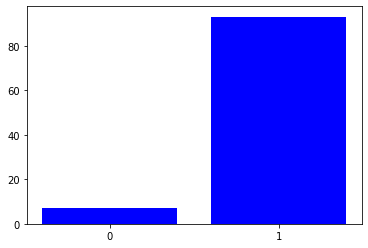

Simulated results:
{'1': 100}


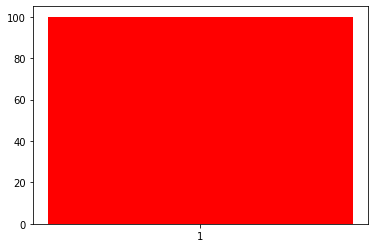

Time taken to create circuit:  0.0008726119995117188
Time taken for simulation:  1.1555984020233154
Time taken by execution:  2.7031469345092773
0.0008726119995117188 1.1555984020233154 2.7031469345092773


In [4]:
(circuitTime, simTime, runTime) = runMainCircuitDJ(1)
print (circuitTime, simTime, runTime)

Correctness Tests

configrc.store_credentials:WARNING:2022-03-17 02:25:24,802: Credentials already present. Set overwrite=True to overwrite.


Input Length:  1
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


ibmqfactory.load_account:WARNING:2022-03-17 02:25:25,269: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
       ┌───┐     ┌──────────┐┌───┐┌─┐
q39_0: ┤ H ├─────┤1         ├┤ H ├┤M├
       ├───┤┌───┐│  Unitary │└───┘└╥┘
q39_1: ┤ X ├┤ H ├┤0         ├──────╫─
       └───┘└───┘└──────────┘      ║ 
 c1: 1/════════════════════════════╩═
                                   0 
IBM Results: 
{'0': 98, '1': 2}


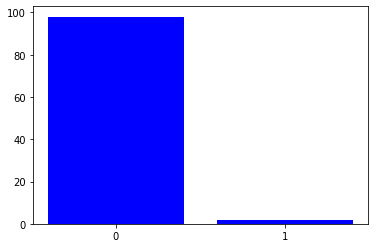

Simulated results:
{'0': 100}


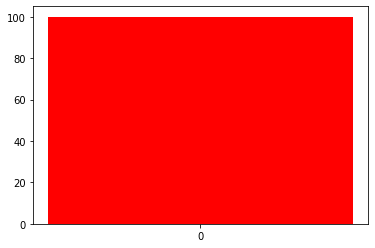

Time taken to create circuit:  0.0010762214660644531
Time taken for simulation:  0.031063079833984375
Time taken by execution:  2.7990641593933105


(0.0010762214660644531, 0.031063079833984375, 2.7990641593933105)

In [5]:
# Constant n = 1
runMainCircuitDJ(1, 0)

configrc.store_credentials:WARNING:2022-03-17 02:30:04,377: Credentials already present. Set overwrite=True to overwrite.


Input Length:  1
Type:  1
Matrix Uf:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


ibmqfactory.load_account:WARNING:2022-03-17 02:30:04,694: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
       ┌───┐     ┌──────────┐┌───┐┌─┐
q74_0: ┤ H ├─────┤1         ├┤ H ├┤M├
       ├───┤┌───┐│  Unitary │└───┘└╥┘
q74_1: ┤ X ├┤ H ├┤0         ├──────╫─
       └───┘└───┘└──────────┘      ║ 
 c2: 1/════════════════════════════╩═
                                   0 
IBM Results: 
{'0': 5, '1': 95}


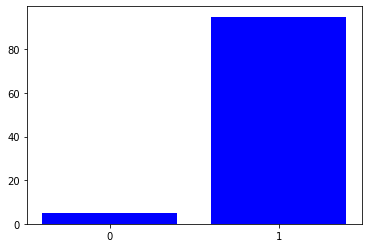

Simulated results:
{'1': 100}


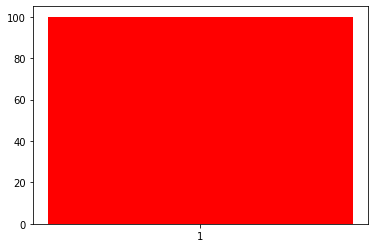

Time taken to create circuit:  0.0015251636505126953
Time taken for simulation:  0.028394222259521484
Time taken by execution:  2.7031362056732178


(0.0015251636505126953, 0.028394222259521484, 2.7031362056732178)

In [6]:
# Uniform n = 1
runMainCircuitDJ(1, 1)

configrc.store_credentials:WARNING:2022-03-17 02:40:54,645: Credentials already present. Set overwrite=True to overwrite.


Input Length:  2
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


ibmqfactory.load_account:WARNING:2022-03-17 02:40:55,003: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
        ┌───┐     ┌──────────┐┌───┐┌─┐   
q115_0: ┤ H ├─────┤2         ├┤ H ├┤M├───
        ├───┤     │          │├───┤└╥┘┌─┐
q115_1: ┤ H ├─────┤1 Unitary ├┤ H ├─╫─┤M├
        ├───┤┌───┐│          │└───┘ ║ └╥┘
q115_2: ┤ X ├┤ H ├┤0         ├──────╫──╫─
        └───┘└───┘└──────────┘      ║  ║ 
  c3: 2/════════════════════════════╩══╩═
                                    0  1 
IBM Results: 
{'00': 65, '01': 8, '10': 23, '11': 4}


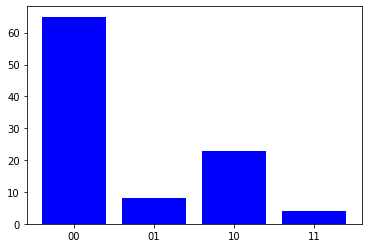

Simulated results:
{'00': 100}


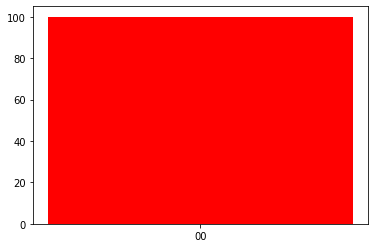

Time taken to create circuit:  0.001005411148071289
Time taken for simulation:  0.05912208557128906
Time taken by execution:  4.018527030944824


(0.001005411148071289, 0.05912208557128906, 4.018527030944824)

In [7]:
# Constant n = 2
runMainCircuitDJ(2, 0)

configrc.store_credentials:WARNING:2022-03-17 02:52:44,341: Credentials already present. Set overwrite=True to overwrite.


Input Length:  2
Type:  1
Matrix Uf:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


ibmqfactory.load_account:WARNING:2022-03-17 02:52:44,610: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
        ┌───┐     ┌──────────┐┌───┐┌─┐   
q185_0: ┤ H ├─────┤2         ├┤ H ├┤M├───
        ├───┤     │          │├───┤└╥┘┌─┐
q185_1: ┤ H ├─────┤1 Unitary ├┤ H ├─╫─┤M├
        ├───┤┌───┐│          │└───┘ ║ └╥┘
q185_2: ┤ X ├┤ H ├┤0         ├──────╫──╫─
        └───┘└───┘└──────────┘      ║  ║ 
  c4: 2/════════════════════════════╩══╩═
                                    0  1 
IBM Results: 
{'00': 12, '01': 12, '10': 21, '11': 55}


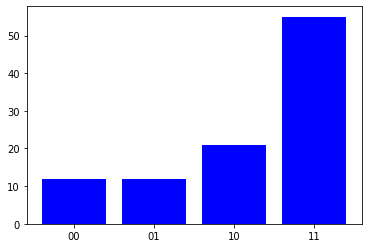

Simulated results:
{'11': 100}


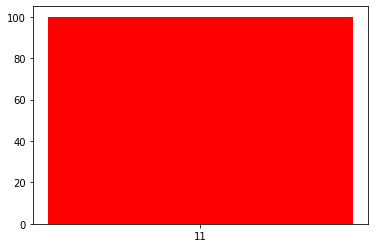

Time taken to create circuit:  0.0008883476257324219
Time taken for simulation:  0.06829404830932617
Time taken by execution:  4.049619436264038


(0.0008883476257324219, 0.06829404830932617, 4.049619436264038)

In [8]:
# Uniform n = 2
runMainCircuitDJ(2, 1)

configrc.store_credentials:WARNING:2022-03-17 03:15:04,786: Credentials already present. Set overwrite=True to overwrite.


Input Length:  3
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


ibmqfactory.load_account:WARNING:2022-03-17 03:15:05,490: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
        ┌───┐     ┌──────────┐┌───┐┌─┐      
q251_0: ┤ H ├─────┤3         ├┤ H ├┤M├──────
        ├───┤     │          │├───┤└╥┘┌─┐   
q251_1: ┤ H ├─────┤2         ├┤ H ├─╫─┤M├───
        ├───┤     │  Unitary │├───┤ ║ └╥┘┌─┐
q251_2: ┤ H ├─────┤1         ├┤ H ├─╫──╫─┤M├
        ├───┤┌───┐│          │└───┘ ║  ║ └╥┘
q251_3: ┤ X ├┤ H ├┤0         ├──────╫──╫──╫─
        └───┘└───┘└──────────┘      ║  ║  ║ 
  c5: 3/════════════════════════════╩══╩══╩═
                                    0  1  2 
IBM Results: 
{'000': 29, '001': 28, '010': 8, '011': 6, '100': 8, '101': 12, '110': 3, '111': 6}


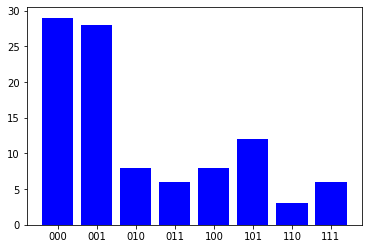

Simulated results:
{'000': 100}


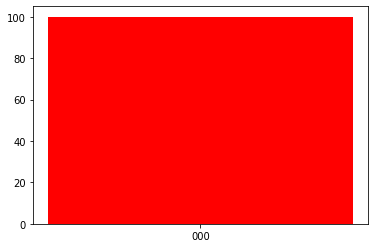

Time taken to create circuit:  0.001264810562133789
Time taken for simulation:  0.0674281120300293
Time taken by execution:  4.719717979431152


(0.001264810562133789, 0.0674281120300293, 4.719717979431152)

In [9]:
# Constant n = 3
runMainCircuitDJ(3, 0)

configrc.store_credentials:WARNING:2022-03-17 03:26:44,914: Credentials already present. Set overwrite=True to overwrite.


Input Length:  3
Type:  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


ibmqfactory.load_account:WARNING:2022-03-17 03:26:45,381: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
        ┌───┐     ┌──────────┐┌───┐┌─┐      
q377_0: ┤ H ├─────┤3         ├┤ H ├┤M├──────
        ├───┤     │          │├───┤└╥┘┌─┐   
q377_1: ┤ H ├─────┤2         ├┤ H ├─╫─┤M├───
        ├───┤     │  Unitary │├───┤ ║ └╥┘┌─┐
q377_2: ┤ H ├─────┤1         ├┤ H ├─╫──╫─┤M├
        ├───┤┌───┐│          │└───┘ ║  ║ └╥┘
q377_3: ┤ X ├┤ H ├┤0         ├──────╫──╫──╫─
        └───┘└───┘└──────────┘      ║  ║  ║ 
  c6: 3/════════════════════════════╩══╩══╩═
                                    0  1  2 
IBM Results: 
{'000': 5, '001': 12, '010': 18, '011': 15, '100': 9, '101': 14, '110': 13, '111': 14}


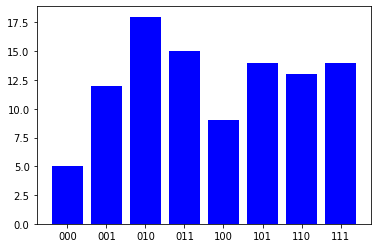

Simulated results:
{'111': 100}


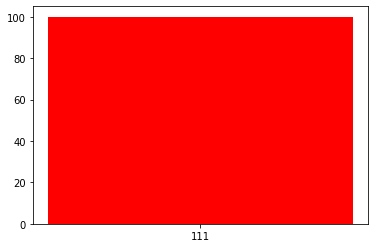

Time taken to create circuit:  0.0013813972473144531
Time taken for simulation:  0.07135272026062012
Time taken by execution:  5.641874313354492


(0.0013813972473144531, 0.07135272026062012, 5.641874313354492)

In [10]:
# Uniform n = 3
runMainCircuitDJ(3, 1)

Input Length:  4
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


configrc.store_credentials:WARNING:2022-03-17 08:47:13,275: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 08:47:13,661: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
         ┌───┐     ┌──────────┐┌───┐┌─┐         
q4509_0: ┤ H ├─────┤4         ├┤ H ├┤M├─────────
         ├───┤     │          │├───┤└╥┘┌─┐      
q4509_1: ┤ H ├─────┤3         ├┤ H ├─╫─┤M├──────
         ├───┤     │          │├───┤ ║ └╥┘┌─┐   
q4509_2: ┤ H ├─────┤2 Unitary ├┤ H ├─╫──╫─┤M├───
         ├───┤     │          │├───┤ ║  ║ └╥┘┌─┐
q4509_3: ┤ H ├─────┤1         ├┤ H ├─╫──╫──╫─┤M├
         ├───┤┌───┐│          │└───┘ ║  ║  ║ └╥┘
q4509_4: ┤ X ├┤ H ├┤0         ├──────╫──╫──╫──╫─
         └───┘└───┘└──────────┘      ║  ║  ║  ║ 
  c33: 4/════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3 
IBM Results: 
{'0000': 6, '0001': 3, '0010': 5, '0011': 3, '0100': 10, '0101': 3, '0110': 7, '0111': 4, '1000': 8, '1001': 8, '1010': 5, '1011': 6, '1100': 11, '1101': 9, '1110': 6, '1111': 6}


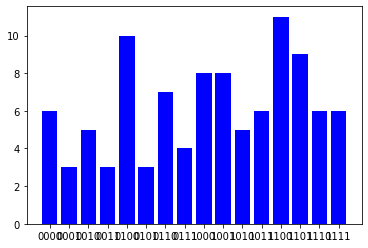

Simulated results:
{'0000': 100}


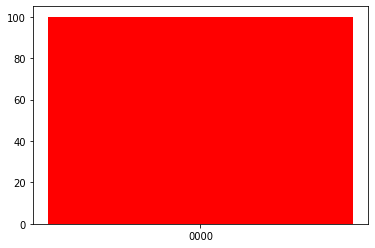

Time taken to create circuit:  0.0051500797271728516
Time taken for simulation:  0.22154784202575684
Time taken by execution:  4.740348815917969


(0.0051500797271728516, 0.22154784202575684, 4.740348815917969)

In [21]:
# Constant n = 4
runMainCircuitDJ(4, 0)

configrc.store_credentials:WARNING:2022-03-17 09:00:19,388: Credentials already present. Set overwrite=True to overwrite.


Input Length:  4
Type:  1
Matrix Uf:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


ibmqfactory.load_account:WARNING:2022-03-17 09:00:19,765: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
         ┌───┐     ┌──────────┐┌───┐┌─┐         
q4858_0: ┤ H ├─────┤4         ├┤ H ├┤M├─────────
         ├───┤     │          │├───┤└╥┘┌─┐      
q4858_1: ┤ H ├─────┤3         ├┤ H ├─╫─┤M├──────
         ├───┤     │          │├───┤ ║ └╥┘┌─┐   
q4858_2: ┤ H ├─────┤2 Unitary ├┤ H ├─╫──╫─┤M├───
         ├───┤     │          │├───┤ ║  ║ └╥┘┌─┐
q4858_3: ┤ H ├─────┤1         ├┤ H ├─╫──╫──╫─┤M├
         ├───┤┌───┐│          │└───┘ ║  ║  ║ └╥┘
q4858_4: ┤ X ├┤ H ├┤0         ├──────╫──╫──╫──╫─
         └───┘└───┘└──────────┘      ║  ║  ║  ║ 
  c34: 4/════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3 
IBM Results: 
{'0000': 10, '0001': 14, '0010': 3, '0011': 4, '0100': 8, '0101': 10, '0110': 5, '0111': 6, '1000': 8, '1001': 8, '1010': 5, '1011': 4, '1100': 2, '1101': 6, '1110': 1, '1111': 6}


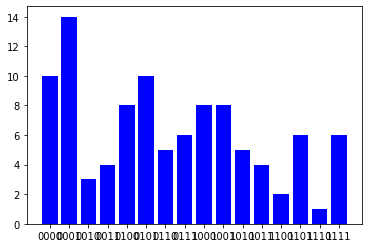

Simulated results:
{'0011': 3, '0001': 5, '1101': 6, '1000': 5, '0101': 27, '0100': 7, '0110': 12, '1110': 29, '1010': 3, '1111': 3}


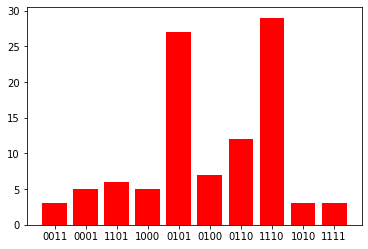

Time taken to create circuit:  0.0059282779693603516
Time taken for simulation:  0.0852959156036377
Time taken by execution:  4.351804733276367


(0.0059282779693603516, 0.0852959156036377, 4.351804733276367)

In [22]:
# Uniform n = 4
runMainCircuitDJ(4, 1)

Time for various Uf for n = 4 and Uniform

configrc.store_credentials:WARNING:2022-03-17 03:36:15,013: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 03:36:15,345: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 03:49:24,591: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 03:49:25,241: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 04:02:43,121: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 04:02:43,542: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 04:22:45,144: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 04:22:45,375: Credentials are alread

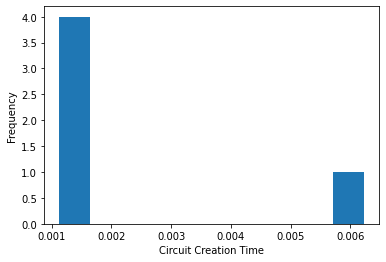

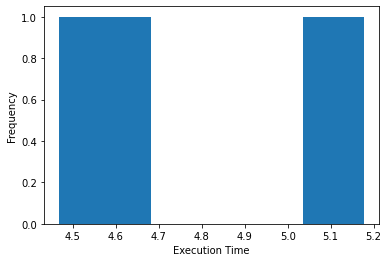

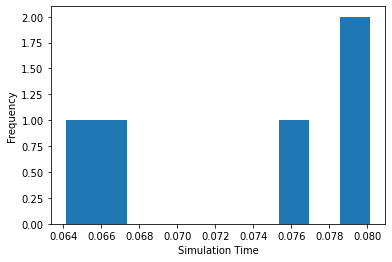

In [11]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(5):
    (circuit, sim, execution) = runMainCircuitDJ(4, 1, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(sim)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Simulation Time')
plt.ylabel('Frequency')
plt.show() 

Time difference for Constant functions (Only 2 possible) for n = 4

configrc.store_credentials:WARNING:2022-03-17 04:51:55,741: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 04:51:55,974: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 04:55:05,609: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 04:55:05,987: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 04:57:34,993: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 04:57:35,265: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 05:09:35,074: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:09:35,348: Credentials are alread

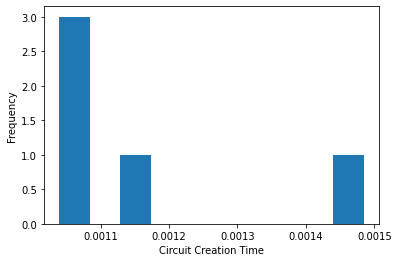

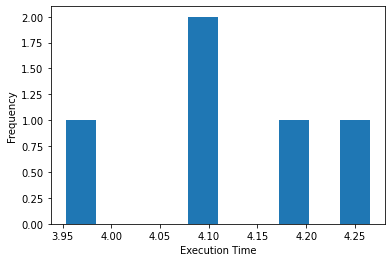

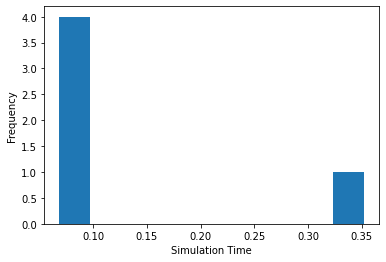

configrc.store_credentials:WARNING:2022-03-17 05:28:27,111: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:28:27,512: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 05:35:35,374: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:35:35,722: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 05:51:15,310: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:51:15,620: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 06:19:55,564: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 06:19:55,916: Credentials are alread

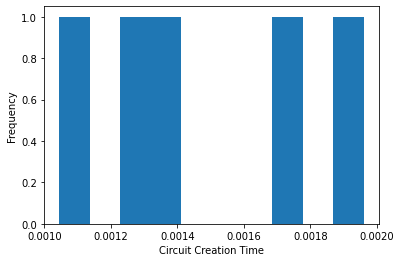

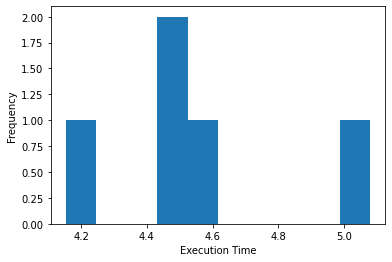

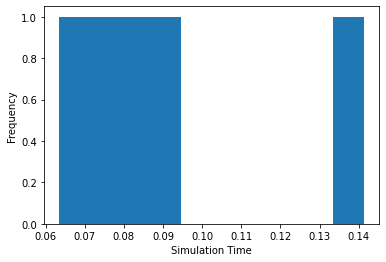

In [14]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(5):
    (circuit, sim, execution) = runMainCircuitDJ(4, 0, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(sim)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Simulation Time')
plt.ylabel('Frequency')
plt.show() 

Effect of n on execution time

configrc.store_credentials:WARNING:2022-03-17 05:19:05,597: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:19:05,933: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 05:21:55,339: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:21:55,641: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 05:23:34,960: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:23:35,345: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 05:25:14,889: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 05:25:15,307: Credentials are alread

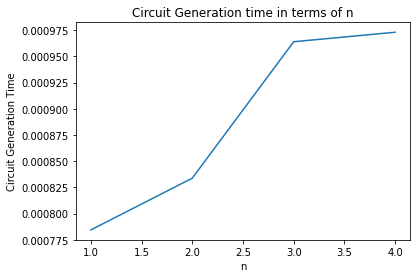

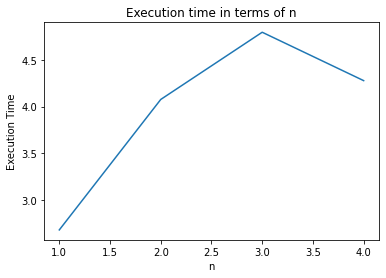

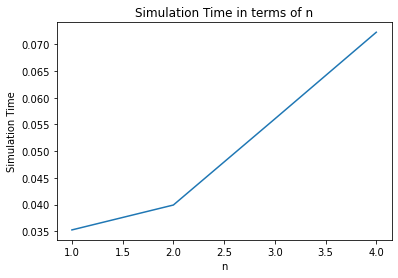

configrc.store_credentials:WARNING:2022-03-17 06:32:46,277: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 06:32:46,656: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 06:39:06,015: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 06:39:06,384: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 06:45:35,494: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 06:45:35,943: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 06:58:15,964: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 06:58:16,361: Credentials are alread

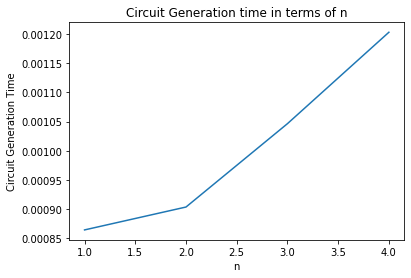

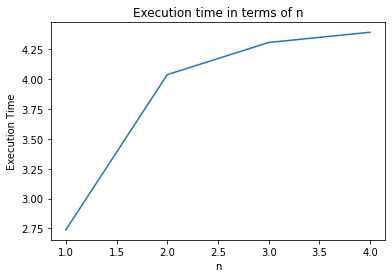

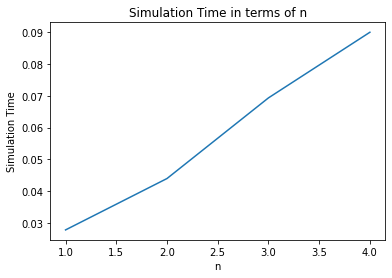

In [15]:
circuitTimes = []
executionTimes = []
totalTimes = []
for n in range(1, 5):
    (circuit, sim, execution) = runMainCircuitDJ(n, 1, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(sim)

x_axis = [1, 2, 3, 4]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Simulation Time in terms of n')
plt.ylabel('Simulation Time')
plt.xlabel('n')
plt.show() 

Success Rate

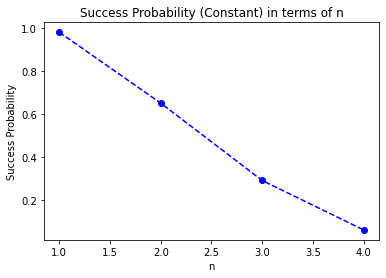

In [24]:
import matplotlib.pyplot as plt
x_axis = [1, 2, 3, 4]
y_axis = [0.98, 0.65, 0.29, 0.06]
plt.plot(x_axis, y_axis, '--bo')
plt.title('Success Probability (Constant) in terms of n')
plt.ylabel('Success Probability')
plt.xlabel('n')
plt.show() 

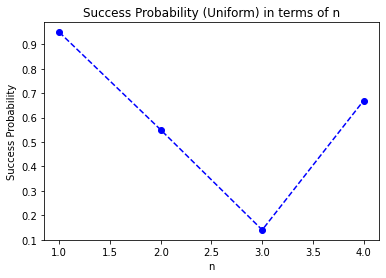

In [23]:
import matplotlib.pyplot as plt
x_axis = [1, 2, 3, 4]
y_axis = [0.95, 0.55, 0.14, 0.67]
plt.plot(x_axis, y_axis, '--bo')
plt.title('Success Probability (Uniform) in terms of n')
plt.ylabel('Success Probability')
plt.xlabel('n')
plt.show() 

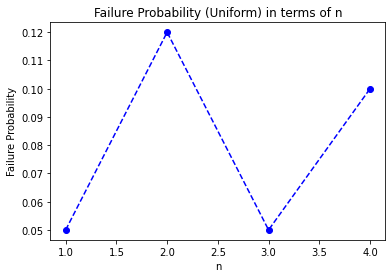

In [26]:
import matplotlib.pyplot as plt
x_axis = [1, 2, 3, 4]
y_axis = [0.05, 0.12, 0.05, 0.1]
plt.plot(x_axis, y_axis, '--bo')
plt.title('Failure Probability (Uniform) in terms of n')
plt.ylabel('Failure Probability')
plt.xlabel('n')
plt.show() 